In [1]:
import cupy as cp

In [ ]:
class LSTM:

    """
    LSTM 神经网络
    """
    
    def __init__(self, input_size: int = None, hidden_size: int = None, output_size: int = None):

        """
        初始化 LSTM 网络的权重矩阵和偏置向量

        Paramters
        ---------
        input_size : 输入维度
        hidden_size : 隐层状态维度
        output_size : 输出维度
        """

        self.hidden_size = hidden_size
        self.output_size = output_size

        self.U_i = cp.random.normal(0, 1, (hidden_size, hidden_size))
        self.U_f = cp.random.normal(0, 1, (hidden_size, hidden_size))
        self.U_o = cp.random.normal(0, 1, (hidden_size, hidden_size))
        self.U_c = cp.random.normal(0, 1, (hidden_size, hidden_size))

        self.W_i = cp.random.normal(0, 1, (hidden_size, input_size))
        self.W_f = cp.random.normal(0, 1, (hidden_size, input_size))
        self.W_o = cp.random.normal(0, 1, (hidden_size, input_size))
        self.W_c = cp.random.normal(0, 1, (hidden_size, input_size))

        self.b_i = cp.random.randn(hidden_size)
        self.b_f = cp.random.randn(hidden_size)
        self.b_o = cp.random.randn(hidden_size)
        self.b_c = cp.random.randn(hidden_size)

        self.V = cp.random.randn(output_size, hidden_size)
        self.b_z = cp.random.randn(output_size)

        self.h_0 = cp.zeros(hidden_size)
        self.c_0 = cp.zeros(hidden_size)

    @ staticmethod
    def sigmoid(X: cp.ndarray = None) -> cp.ndarray:

        """
        sigmoid 激活函数

        Parameters
        ----------
        X : 特征数据集

        Returns
        -------
        value : 对特征数据进行非线性变换后的取值
        """
        
        value = 1 / (1 + cp.exp( - X))

        return value
    
    @ staticmethod
    def tanh(z: cp.ndarray = None) -> cp.ndarray:

        """
        tanh 激活函数

        Parameters
        ----------
        z : 净输入
        
        Returns
        -------
        y : 激活值
        """
        
        y = (cp.exp(z) - cp.exp( - z)) / (cp.exp(z) + cp.exp( - z))
        
        return y
    
    @ staticmethod
    def softmax(z: cp.ndarray = None, dim: int = 1) -> cp.ndarray:
        
        """
        softmax 函数

        Parameters
        ----------
        z : 净输入
        
        Returns
        -------
        y : 激活值
        """
        
        y = cp.exp(z) / cp.expand_dims(cp.sum(cp.exp(z), axis = dim), axis = -1)
        
        return y
    
    # 单个 LSTM 单元
    def LSTM_cell(self, x: cp.ndarray = None, c: cp.ndarray = None, h: cp.ndarray = None) -> tuple[cp.ndarray, tuple[cp.ndarray, cp.ndarray, cp.ndarray], cp.ndarray, cp.ndarray, cp.ndarray]:

        """
        LSTM 单元，将 t 时刻的输入 x 和 t-1 时刻的隐层状态输出 c、h 转换为 t 时刻的预测值 y_hat 和隐层状态输出 i、f、o、c_wave、c、h

        Paramters
        ---------
        x : 输入张量，形状为 [batch_size, 1, input_size]
        c : 前一时刻的细胞状态，形状为 [batch_size, 1, hidden_size]
        h : 前一时刻的隐层状态，形状为 [batch_size, 1, hidden_size]

        Returns
        -------
        y_hat : LSTM 单元当前时刻的预测值，形状为 [batch_size, output_size]
        i : 当前时刻的输入门，形状为 [batch_size, hidden_size]
        f : 当前时刻的遗忘门，形状为 [batch_size, hidden_size]
        o : 当前时刻的输出门，形状为 [batch_size, hidden_size]
        c_wave : 当前时刻的 c_wave ，形状为 [batch_size, hidden_size]
        c : 当前时刻的细胞状态输出，形状为 [batch_size, hidden_size]
        h : 当前时刻的隐层状态输出，形状为 [batch_size, 1, hidden_size]
        """

        i = self.sigmoid(cp.sum(self.U_i * h, axis = -1) + cp.sum(self.W_i * x, axis = -1) + self.b_i)
        f = self.sigmoid(cp.sum(self.U_f * h, axis = -1) + cp.sum(self.W_f * x, axis = -1) + self.b_f)
        o = self.sigmoid(cp.sum(self.U_o * h, axis = -1) + cp.sum(self.W_o * x, axis = -1) + self.b_o)

        c_wave = self.tanh(cp.sum(self.U_c * h, axis = -1) + cp.sum(self.W_c * x, axis = -1) + self.b_c)
        c = i * c_wave + f * c
        h = o * self.tanh(c)
        h = cp.expand_dims(h, axis = 1)
        z = cp.sum(self.V * h, axis = -1) + self.b_z

        yt_hat = self.softmax(z, dim = 1)

        return yt_hat, (i, f, o), c_wave, c, h

    def forward(self, X: cp.ndarray = None) -> tuple[cp.ndarray, cp.ndarray, cp.ndarray]:

        """
        前向传播计算预测值

        Paramters
        ---------
        X : 输入张量，形状为 [time_steps, batch_size, input_size]

        Returns
        -------
        y_hat : 全部时刻的预测值，形状为 [batch_size, output_size]
        total_c : 全部时刻的细胞状态，形状为 [batch_size, hidden_size]
        total_h : 全部时刻的隐层状态，形状为 [batch_size, hidden_size]
        """

        y_hat = []

        c = self.c_0
        h = self.h_0

        self.i = []
        self.f = []
        self.o = []
        self.c_wave = []

        total_c = []
        total_h = []
        
        for t in range(len(X)):
            
            x = cp.expand_dims(X[t], axis = 1)
            yt_hat, (i, f, o), c_wave, c, h = self.LSTM_cell(x, c, h)

            self.i.append(cp.expand_dims(i, axis = 0))
            self.f.append(cp.expand_dims(f, axis = 0))
            self.o.append(cp.expand_dims(o, axis = 0))
            self.c_wave.append(cp.expand_dims(c_wave, axis = 0))

            total_c.append(cp.expand_dims(c, axis = 0))
            total_h.append(cp.expand_dims(h.squeeze(1), axis = 0))

            y_hat.append(cp.expand_dims(yt_hat, axis = 0))
        
        self.i = cp.vstack(self.i)
        self.f = cp.vstack(self.f)
        self.o = cp.vstack(self.o)
        self.c_wave = cp.vstack(self.c_wave)

        total_c = cp.vstack(total_c)
        total_h = cp.vstack(total_h)
        y_hat = cp.vstack(y_hat)

        return y_hat, total_c, total_h
    
    def backward(self, X: cp.ndarray = None, y: cp.ndarray = None, lr: float = 0.01):

        """
        反向传播计算梯度

        Paramters
        ---------
        X : 输入张量，形状为 [time_steps, batch_size, input_size]
        y : 输入张量，形状为 [time_steps, output_size]
        lr : 学习率
        """

        time_steps = len(X)
        batch_size = X.shape[1]

        y_hat, total_c, total_h = self.forward(X)

        X = cp.expand_dims(X, axis = 2)
        total_h = cp.expand_dims(total_h, axis = 2)
        

        h_delta = cp.sum(self.V.T * cp.expand_dims((y_hat[-1] - y[-1]), axis = 1), axis = -1)

        i = self.i[-1]
        f = self.f[-1]
        o = self.o[-1]
        c = total_c[-1]
        c_wave = self.c_wave[-1]

        h = total_h[-2]
        x = X[-1]

        tanh_c = self.tanh(c)

        c_delta = h_delta * o * (1 - tanh_c ** 2)
        
        L = c_delta  * c_wave * i * (1 - i)
        L_Ui = L.reshape(batch_size, self.hidden_size, 1) @ h
        L_Wi = L.reshape(batch_size, self.hidden_size, 1) @ x
        L_bi = L
        
        L = c_delta  * c * f * (1 - f)
        L_Uf = L.reshape(batch_size, self.hidden_size, 1) @ h
        L_Wf = L.reshape(batch_size, self.hidden_size, 1) @ x
        L_bf = L
        
        L = c_delta * i * (1 - c_wave ** 2)
        L_Uc = L.reshape(batch_size, self.hidden_size, 1) @ h
        L_Wc = L.reshape(batch_size, self.hidden_size, 1) @ x
        L_bc = L
        
        L = h_delta * tanh_c * o * (1 - o)
        L_Uo = L.reshape(batch_size, self.hidden_size, 1) @ h
        L_Wo = L.reshape(batch_size, self.hidden_size, 1) @ x
        L_bo = L
        
        L = y_hat[-1] - y[-1]
        L_V = L.reshape(batch_size, self.output_size, 1) @ h
        L_bz = L

        for t in range(time_steps - 1, 0, -1):

            i = self.i[t]
            f = self.f[t]
            o = self.o[t]
            c = total_c[t]
            c_1 = total_c[t-1]
            c_wave = self.c_wave[t]

            tanh_c = self.tanh(c)
            
            p1 = cp.sum(self.V.T * cp.expand_dims((y_hat[t - 1] - y[t - 1]), axis = 1), axis = -1)
            p2 = cp.sum(self.U_i.T * cp.expand_dims((c_delta *  i * (1 - i) * c_wave), axis = 1), axis = -1)
            p3 = cp.sum(self.U_c.T * cp.expand_dims((c_delta * i * (1 - c_wave ** 2)), axis = 1), axis = -1)
            p4 = cp.sum(self.U_f.T * cp.expand_dims((c_delta * f * (1 - f) * c_1), axis = 1), axis = -1)
            p5 = cp.sum(self.U_o.T * cp.expand_dims((h_delta * o * (1 - o) * tanh_c), axis = 1), axis = -1)
            
            h_delta = p1 + p2 + p3 + p4 + p5

            i = self.i[t - 1]
            f = self.f[t - 1]
            o = self.o[t - 1]
            c = total_c[t - 1]
            c_wave = self.c_wave[t - 1]

            c_delta = h_delta * o * (1 - tanh_c ** 2) + c_delta * f

            if t > 1:
                
                c = total_c[t-2]
                h = total_h[t-2]
                
                L_Ui_t = (c_delta * c_wave * i * (1 - i)).reshape(batch_size, self.hidden_size, 1) @ h
                L_Ui += L_Ui_t
                
                L_Uf_t = (c_delta * c * f * (1 - f)).reshape(batch_size, self.hidden_size, 1) @ h
                L_Uf += L_Uf_t
                
                L_Uc_t = (c_delta * i * (1 - c_wave ** 2)).reshape(batch_size, self.hidden_size, 1) @ h
                L_Uc += L_Uc_t
                
                L_Uo_t = (h_delta * tanh_c * o * (1 - o)).reshape(batch_size, self.hidden_size, 1) @ h
                L_Uo += L_Uo_t
            
            x = X[t-1]

            L = c_delta * c_wave * i * (1 - i)
            L_Wi_t = L.reshape(batch_size, self.hidden_size, 1) @ x
            L_Wi += L_Wi_t
            L_bi_t = L
            L_bi += L_bi_t
            
            L = c_delta * c * f * (1 - f)
            L_Wf_t = L.reshape(batch_size, self.hidden_size, 1) @ x
            L_Wf += L_Wf_t
            L_bf_t = L
            L_bf += L_bf_t
            
            L = c_delta * i * (1 - c_wave ** 2)
            L_Wc_t = L.reshape(batch_size, self.hidden_size, 1) @ x
            L_Wc += L_Wc_t
            L_bc_t = L
            L_bc += L_bc_t
            
            L = h_delta * tanh_c * o * (1 - o)
            L_Wo_t = L.reshape(batch_size, self.hidden_size, 1) @ x
            L_Wo += L_Wo_t
            L_bo_t = L
            L_bo += L_bo_t
            
            L = y_hat[t - 1] - y[t - 1]
            L_V_t = L.reshape(batch_size, self.output_size, 1) @ total_h[t - 1]
            L_V += L_V_t
            L_bz_t = L
            L_bz += L_bz_t

        L_Ui = cp.mean(L_Ui, axis = 0)
        L_Wi = cp.mean(L_Wi, axis = 0)
        L_bi = cp.mean(L_bi, axis = 0)

        L_Uf = cp.mean(L_Uf, axis = 0)
        L_Wf = cp.mean(L_Wf, axis = 0)
        L_bf = cp.mean(L_bf, axis = 0)

        L_Uo = cp.mean(L_Uo, axis = 0)
        L_Wo = cp.mean(L_Wo, axis = 0)
        L_bo = cp.mean(L_bo, axis = 0)

        
        L_Uc = cp.mean(L_Uc, axis = 0)
        L_Wc = cp.mean(L_Wc, axis = 0)
        L_bc = cp.mean(L_bc, axis = 0)

        L_V = cp.mean(L_V, axis = 0)
        L_bz = cp.mean(L_bz, axis = 0)

        self.U_i -= lr * L_Ui
        self.U_f -= lr * L_Uf
        self.U_o -= lr * L_Uo
        self.U_c -= lr * L_Uc

        self.W_i -= lr * L_Wi
        self.W_f -= lr * L_Wf
        self.W_o -= lr * L_Wo
        self.W_c -= lr * L_Wc

        self.b_i -= lr * L_bi
        self.b_f -= lr * L_bf
        self.b_o -= lr * L_bo
        self.b_c -= lr * L_bc

        self.V -= lr * L_V
        self.b_z -= lr * L_bz

In [3]:
sen = """会不会我们的爱，像星辰守护大海，不曾离开？我向你奔赴而来，你就是星辰大海。我眼中炽热的恒星，长夜里照我前行。"""

In [4]:
import jieba
vocabs = [vocab for vocab in jieba.cut(sen)]
vocabs = ["<begin>", "《星辰大海》", "歌手：黄霄云"] + vocabs + ["<end>"]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LIANGX~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.378 seconds.
Prefix dict has been built successfully.


In [5]:
import numpy as np
word = np.unique(vocabs)
word_dict = {}
vocab_dict = {}
for i in range(len(word)):
    emb = [0] * len(word)
    emb[i] = 1
    word_dict[word[i]] = emb
    vocab_dict[i] = word[i]
input_size = len(word)
hidden_size = 10
output_size = len(word)
X = cp.array([[word_dict[vocab]] for vocab in vocabs[:-1]])
y = cp.array([[word_dict[vocab]] for vocab in vocabs[1:]])

In [6]:
# 实例化 LSTM 循环神经网络
lstm = LSTM(input_size, hidden_size, output_size)

In [7]:
# 定义评估函数
def eval(y: cp.ndarray = None, y_hat: cp.ndarray = None) -> cp.ndarray:
        
    """
    评估模型表现

    Parameters
    ----------
    y : 真实标签
    y_hat : 预测标签

    Returns
    -------
    loss : 交叉熵损失值
    """
    
    # loss 为标量，将单个样本每个类别、每个时刻的损失累加在一起得到单个样本的交叉熵损失，最后对所有样本的损失求平均
    ## y * cp.log(y_hat) 形状为 [time_step, batch_size, output_size]
    ## cp.sum(y * cp.log(y_hat), axis = -1) 形状为 [time_step, batch_size]
    ## cp.sum(cp.sum(y * cp.log(y_hat), axis = -1), axis = 0) 形状为 batch_size
    loss = - cp.sum(cp.sum(y * cp.log(y_hat), axis = -1), axis = 0)
    loss = cp.mean(loss).item()

    return loss

In [8]:
train_loss = []
# 训练 100 次
for i in range(100):
    
    # 反向传播更新参数
    lstm.backward(X, y, lr = 0.5)
    # 前向传播评估算法表现
    y_hat, c, h = lstm.forward(X)
    # 评估本次更新参数后的算法表现
    loss = eval(y, y_hat)
    print(loss)
    train_loss.append(loss)

205.53433690616552
178.04715727381102
158.25692063803396
145.6881925365595
140.70027971686864
136.88039777259695
132.51665142055288
128.56386136197256
125.84509677116176
123.06913927432568
119.70798168154995
115.80330127040921
112.49953559272188
116.45639669422715
126.72975741741928
110.02301964346879
101.23530914348208
97.63390110184406
94.9926581210144
92.88016258630029
91.67544945057372
90.3032124554162
91.98177807308998
91.34171014219586
98.09898498943885
91.69112115581227
94.42273584104
86.01082750747902
87.62586802082095
81.22068491213611
90.8612040918269
74.74641089658695
72.85220447229206
67.30311106990743
64.13688245150112
62.871590699764425
60.76721610613294
68.38810536536106
59.37797223427779
71.48889968171216
60.31839287306268
52.3395536759979
48.46548694886386
45.95293409086779
47.85458846825608
56.77485681478609
57.31453790898877
54.58977135239216
42.18893662655709
51.235406314451794
44.352791957293
41.144262870942036
34.094018392129406
33.26185614672622
34.78047442310743

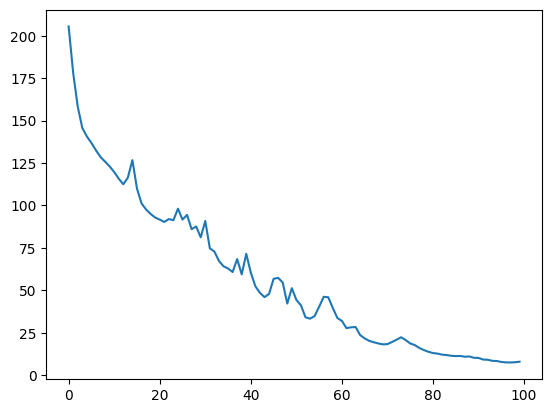

In [9]:
# 损失函数下降情况
import matplotlib.pyplot as plt
plt.plot(train_loss)

In [10]:
import time

# LSTM 背诵歌词
c = cp.zeros(hidden_size)
h = cp.zeros(hidden_size)
for i in range(X.shape[0]):
    
    yt_hat, (i, f, o), c_wave, c, h = lstm.LSTM_cell(cp.expand_dims(X[i], axis = 1), c, h)
    if list(word_dict.keys())[cp.argmax(yt_hat.squeeze(0), axis = -1).item()] == "<end>":
        break
    print(list(word_dict.keys())[cp.argmax(yt_hat.squeeze(0), axis = -1).item()])
    time.sleep(0.5)

《星辰大海》
歌手：黄霄云
会
不会
我们
的
爱
，
像
星辰
守护
大海
，
不曾
离开
？
我
向
你
奔赴
而
来
，
你
就是
星辰
大海
。
我
眼中
炽热
的
恒星
，
长
夜里
照
我
前行
。
